# Introducción a las Simulaciones Numéricas
## TP2 - Montecarlo

_Nicolás Vazquez - 6/5/21_

### Introducción

Consideremos un sistema de spines arreglados en los nodos de una red (como en un cristal). Digamos que cada spin tiene dos estados posibles, $\uparrow,\downarrow$, a los cuales asignamos los valores numéricos $\pm 1$. Dos spines vecinos tienen una energía de interacción $E = -Js_is_j$, siendo $J>0$ la constante de esa interacción. Esta energía de interacción tiene entonces algunos valores posibles:

$$\begin{align*}
    \uparrow\uparrow   &\equiv(+1)(+1)\to -J \\
    \uparrow\downarrow &\equiv(+1)(-1)\to +J \\
    \downarrow\uparrow &\equiv(-1)(+1)\to +J \\
    \downarrow\downarrow &\equiv(+1)(+1)\to -J,
\end{align*}$$

de lo que se sigue que los estados de mínima energía tienen los spines _alineados_.

La energía magnética total del sistema la encontramos haciendo interactuar a cada spin con sus vecinos (esto es una _intaracción de corto alcance_), mas, eventualmente, algún campo magnético externo $H$:

$$\begin{equation}
E = \mathcal{H} = -J\sum_{i,j\in nn} s_is_j - gH\sum_is_i.
\end{equation}$$

La primera suma es simple, y se hace sumando cada energía de interacción de spines que sean primeros vecinos. _Sumamos una vez con cada spin_. Esta energía es el hamiltoniano si ignoramos la energía cinética de los átomos. 

La idea central del modelo es que cada spin puede invertirse espontáneamente si así disminuye la energía de interacción.

$$\underset{E_{n}=+2J}{\begin{array}{ccc}
\cdots & \downarrow & \cdots\\
\uparrow & \downarrow & \uparrow\\
\cdots & \uparrow & \cdots
\end{array}}\quad\underset{\Longrightarrow}{\textrm{flip}}\quad\underset{E_{n+1}=-2J}{\begin{array}{ccc}
\cdots & \downarrow & \cdots\\
\uparrow & \uparrow & \uparrow\\
\cdots & \uparrow & \cdots
\end{array}}$$

En el ejemplo de la figura se ve el flip con un vecindario de von Neumann (4 vecinos). La inversión disminuye la energía local de $+2J$ a $-2J$. La transición inversa, que cuesta energía, no podría ocurrir.

La regla de evolución del sistema entonces es: 

 1. A cada step, para cada spin $i$, calcular la energía $E$, y la energía $E'$ con el spin $i$ flipeado. 
 2. Si $E'\leq E$, flipear $i$.
 
En una simulación de $N\times N$ spines, hay $2^{N^2}$ estados posibles. Sólo dos de ellos, con todos los spines alineados, tienen la mínima energía. 
 
### Algoritmo de Metrópolis
Después seguimos...!

El algoritmo consiste en lo siguiente: 
1. Estado inicial aleatorio
2. Calcular energía y magnetización.
3. Bucle temporal de 1 a $N\times N\times t_max$:
    1. Elegir un sitio $(i,j)$ al azar.
    2. Calcular $\Delta E$ correspondiente al flip del sitio elegido. 
    3. Calcular el factor de Boltzmann, $p = e^{-\Delta E/kT}$.
    4. Sortear uniformemente un $w\in(0,1)$:
        - Si $w>p$, rechazar el flip. 
        - Si $w\leq p$, aceptar el flip, actualizar la energía.
    5. Repetir 3.
    
Cada $N^2$ pasos hay que guardar tiempo (pasos sobre $N^2$), energía y magnetización. 

Uno de las operaciones más costosas del algoritmo es el cálculo de la exponencial. Hay una manera sencilla de acelerar este paso: como $\Delta E$ toma solo unos pocos valores discretos posibles, todos los valores de la exponencial pueden calcularse de antemano y almacenarlos en un vector. En cada step de Monte Carlo, después hay que usar el valor de $\Delta E$ que nos da el flip para buscar en el vector la componente correspondiente.

### Armemos la primer corrida...

#### Condiciones de borde?

Hay una sutileza que tenemos que considerar, y es la cuestión de los bordes del sistema. 

Tenemos dos opciones: condiciones de borde libres (los bordes tienen menos vecinos), o condiciones de borde periódicas. 

El caso de las condiciones de borde periódicas es el primero que vamos a escribir, puesto que tenemos código de referencia en mano. Después estudiamos el otro caso. 

El truquito que utilizan para simplificar el código en este caso es implementar _nodos fantasma_ en los bordes, para poder calcular los cambios de energía sin modificar mucho los cálculos. 

##### Condiciones de borde periódicas

Definimos la grilla; cada uno de los spines lo vamos a representar con un `bool` (`True` o `False`), que vamos a identificar con el estado _up_ o _down_ respectivamente. 

In [1]:
# Librerías
import numpy as np
from matplotlib import pyplot as plt
import random
%matplotlib inline

In [2]:
# INICIALIZACIÓN DE PARÁMETROS
#Tamaño de grilla y grilla
N = 32 
grid = np.zeros((N+2,N+2),dtype=np.bool_)
# Energía y magnetización
E = 0
M = 0
#Tiempo total de simulación
tmax = 1000
#Temperatura
T = 1.5
#Valores posibles del factor p de Boltzmann
pb = np.exp((-1/T)*np.array([0,4,8,-8,-4]))

random.seed(84048) #Semilla, para obtener resultados reproducibles

In [3]:
# INICIALIZACIÓN ALEATORIA DEL SISTEMA
for i in range(N+2):
    for j in range(N+2):
        a = random.randint(0,1)
        grid[i,j] = np.bool_(a)

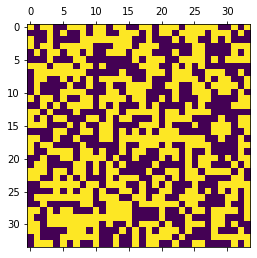

In [4]:
# Representación del estado inicial del sistema
plt.matshow(grid)
plt.show()

In [5]:
# CONDICIONES DE BORDE PERIÓDICAS
for i in range(N+2):
    grid[i,N+1] = grid[i,0]
    grid[N+1,i] = grid[0,i]

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


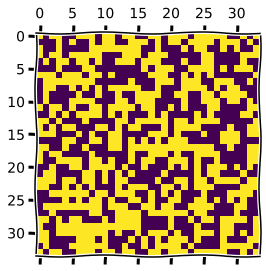

In [6]:
# Gráfico con los spines fantasma
with plt.xkcd():
    plt.matshow(grid)
    plt.show()

In [7]:
# ENERGÍA/MAGNETIZACIÓN INICIAL
for i in range(1,N+1):
    for j in range(1,N+1):
        # Magnetización
        if grid[i,j]: M+=1
        else: M-=1
        # Energía
        if grid[i,j]==grid[i,j+1]: E-=1
        else:E+=1
        if grid[i,j]==grid[i,j-1]: E-=1
        else:E+=1
        if grid[i,j]==grid[i+1,j]: E-=1
        else:E+=1
        if grid[i,j]==grid[i-1,j]: E-=1
        else:E+=1

Como estamos tomando cada par de vecinos dos veces, la energía al final del bucle tenemos que dividirla por la mitad.

In [8]:
E = E/2
E_prom = E/(N*N)
M_prom = M/(N*N)
spin_up = np.count_nonzero(grid[1:N+1,1:N+1]==True)
spin_down = np.count_nonzero(grid[1:N+1,1:N+1]==False)

Con todos los elementos inicializados, ahora podemos armar el bucle temporal con el algoritmo de Metropolis.

In [10]:
Energia=[]
Magnetizacion=[]

Energia.append(E_prom)
Magnetizacion.append(M_prom)
for t in range(tmax):
    for step in range(N*N):
        # i,j al azar:
        deltaE = 0
        i = random.randint(1,N)
        j = random.randint(1,N)
        # Energía
        # Calculamos deltaE = E_f-E_0 = -2*E_0
        if grid[i,j]==grid[i,j+1]: deltaE-=1
        else:deltaE+=1
        if grid[i,j]==grid[i,j-1]: deltaE-=1
        else:deltaE+=1
        if grid[i,j]==grid[i+1,j]: deltaE-=1
        else:deltaE+=1
        if grid[i,j]==grid[i-1,j]: deltaE-=1
        else:deltaE+=1
        deltaE = -2* deltaE
        
        # Actualización del sistema:
        w = random.random()
        p = np.exp(-deltaE/T)
        if w<=p:
            grid[i,j] = not grid[i,j]
            if grid[i,j]==True:
                M+=1
            else: M-=1
            E = E + deltaE
            
        # Actualización de los spines fantasma:
        if i==1: grid[N+1,j] = grid[i,j]
        if i==N: grid[0,j] = grid[i,j]
        if j==1: grid[i,N+1] = grid[i,j]
        if j==N: grid[i,0] = grid[i,j]
    if t%50==0:
        Energia.append(E/(N*N))
        Magnetizacion.append(M/(N*N))

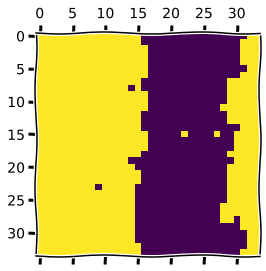

In [11]:
with plt.xkcd():
    plt.matshow(grid)
    plt.show()

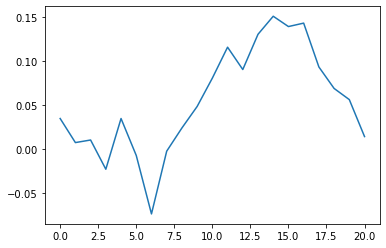

In [12]:
plt.plot(Magnetizacion)
plt.show()

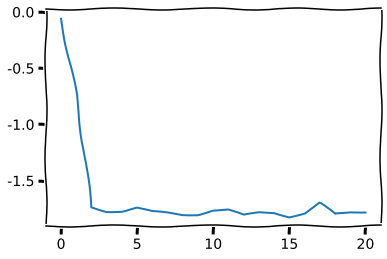

In [13]:
with plt.xkcd():
    plt.plot(Energia)
    plt.show()

##### Condiciones de borde no periódicas

Hay que hacer ligeras modificaciones al código; los bordes tienen menos vecinos que mirar. 

Deberíamos ahora, para poder seguir usando la técnica de ir a buscar los factores de Boltzmann a un vectorcito, considerar los bordes y esquinas como casos aparte.

Ya que estamos, pensando en lo que viene, vamos a ir juntando algo del código que escribimos en forma de funciones. 

In [ ]:
N = 32
tmax = 5000
T = 2.25

In [ ]:
def iniciar_fbc(N,tmax,T):
    # INICIALIZACIÓN DE PARÁMETROS
    #Tamaño de grilla y grilla
    grid = np.zeros((N,N),dtype=np.bool_)
    # Energía y magnetización
    E = 0
    M = 0
    #Tiempo total de simulación
    tmax = tmax
    # Valores aleatorios en los spines del sistema
    for i in range(N):
        for j in range(N):
            a = random.randint(0,1)
            grid[i,j] = np.bool_(a)
    return grid,E,M
grid,E,M = iniciar_fbc(N,tmax,T)

In [ ]:
with plt.xkcd():
    plt.matshow(grid)
    plt.show()

In [ ]:
# ENERGÍA/MAGNETIZACIÓN INICIAL

# Tratamos las esquinas aparte...

# Esq superior izq
if grid[0,0]==grid[0,1]: E-=1
else: E+=1
if grid[0,0]==grid[1,0]: E-=1
else: E+=1
if grid[0,0]: M+=1
else: M-=1

# Esq superior derecha
if grid[0,N-1]==grid[0,N-2]: E-=1
else: E+=1
if grid[0,N-1]==grid[1,N-2]: E-=1
else: E+=1
if grid[0,N-1]: M+=1
else: M-=1 

# Esq inferior izquierda
if grid[N-1,0]==grid[N-2,0]: E-=1
else: E+=1
if grid[N-1,0]==grid[N-1,1]: E-=1
else: E+=1
if grid[N-1,0]: M+=1
else: M-=1 

# Esq inferior derecha
if grid[N-1,N-1]==grid[N-1,N-2]: E-=1
else: E+=1
if grid[N-1,N-1]==grid[N-2,N-1]: E-=1
else: E+=1
if grid[N-1,N-1]: M+=1
else: M-=1 

In [ ]:
# Ahora tomamos los bordes descontando las esquinas
for i in range(1,N-1):
    #Izquierda
    if grid[i,0]==grid[i-1,0]: E-=1
    else: E+=1
    if grid[i,0]==grid[i+1,0]: E-=1
    else: E+=1
    if grid[i,0]==grid[i,1]: E-=1
    else: E+=1
    if grid[i,0]: M+=1
    else: M-=1
    # Derecha    
    if grid[i,N-1]==grid[i-1,N-1]: E-=1
    else: E+=1
    if grid[i,N-1]==grid[i+1,N-1]: E-=1
    else: E+=1
    if grid[i,N-1]==grid[i,N-2]: E-=1
    else: E+=1
    if grid[i,N-1]: M+=1
    else: M-=1
    # Arriba
    if grid[0,i]==grid[0,i-1]: E-=1
    else: E+=1
    if grid[0,i]==grid[0,i+1]: E-=1
    else: E+=1
    if grid[0,i]==grid[1,i]: E-=1
    else: E+=1
    if grid[0,i]: M+=1
    else: M-=1
    # Abajo
    if grid[N-1,i]==grid[N-1,i-1]: E-=1
    else: E+=1
    if grid[N-1,i]==grid[N-1,i+1]: E-=1
    else: E+=1
    if grid[N-1,i]==grid[N-2,i]: E-=1
    else: E+=1
    if grid[0,i]: M+=1
    else: M-=1 

In [ ]:
# Ahora podemos hacer los demás igual que en el caso de borde periódico
for i in range(1,N-1):
    for j in range(1,N-1):
        # Magnetización
        if grid[i,j]: M+=1
        else: M-=1
        # Energía
        if grid[i,j]==grid[i,j+1]: E-=1
        else:E+=1
        if grid[i,j]==grid[i,j-1]: E-=1
        else:E+=1
        if grid[i,j]==grid[i+1,j]: E-=1
        else:E+=1
        if grid[i,j]==grid[i-1,j]: E-=1
        else:E+=1

In [ ]:
Energia=[]
Magnetizacion=[]

Energia.append(E/(N*N))
Magnetizacion.append(M/(N*N))
for t in range(tmax):
    for step in range(N*N):
        # i,j al azar:
        deltaE = 0
        i = random.randint(0,N-1)
        j = random.randint(0,N-1)
        # Energía
        if i==0: # Arriba
            if j==0:
                if grid[i,j]==grid[0,1]: deltaE-=1
                else: deltaE+=1
                if grid[0,0]==grid[1,0]: deltaE-=1
                else: deltaE+=1
            elif j==N-1:
                if grid[i,j]==grid[0,N-2]: deltaE-=1
                else: E+=1
                if grid[i,j]==grid[1,N-2]: deltaE-=1
                else: deltaE+=1
            else:
                if grid[0,j]==grid[0,j-1]: deltaE-=1
                else: deltaE+=1
                if grid[0,j]==grid[0,j+1]: deltaE-=1
                else: deltaE+=1
                if grid[0,j]==grid[1,j]: deltaE-=1
                else: deltaE+=1  
        elif i==N-1: # Abajo
            if j==0:
                if grid[i,j]==grid[N-2,0]: deltaE-=1
                else: deltaE+=1
                if grid[i,j]==grid[N-1,1]: deltaE-=1
                else: deltaE+=1
            elif j==N-1:
                if grid[i,j]==grid[N-1,N-2]: deltaE-=1
                else: deltaE+=1
                if grid[i,j]==grid[N-2,N-1]: deltaE-=1
                else: deltaE+=1
            else:
                if grid[i,j]==grid[N-1,j-1]: deltaE-=1
                else: deltaE+=1
                if grid[i,j]==grid[N-1,j+1]: deltaE-=1
                else: deltaE+=1
                if grid[N-1,i]==grid[i-1,j]: deltaE-=1
                else: deltaE+=1
        elif j==0:
            if grid[i,0]==grid[i-1,0]: deltaE-=1
            else: deltaE+=1
            if grid[i,0]==grid[i+1,0]: deltaE-=1
            else: deltaE+=1
            if grid[i,0]==grid[i,1]: deltaE-=1
            else: deltaE+=1
        elif j==N-1:
            if grid[i,N-1]==grid[i-1,N-1]: deltaE-=1
            else: deltaE+=1
            if grid[i,N-1]==grid[i+1,N-1]: deltaE-=1
            else: deltaE+=1
            if grid[i,N-1]==grid[i,N-2]: deltaE-=1
            else: deltaE+=1
        else:
            if grid[i,j]==grid[i,j+1]: deltaE-=1
            else:deltaE+=1
            if grid[i,j]==grid[i,j-1]: deltaE-=1
            else:deltaE+=1
            if grid[i,j]==grid[i+1,j]: deltaE-=1
            else:deltaE+=1
            if grid[i,j]==grid[i-1,j]: deltaE-=1
            else:deltaE+=1
       
        deltaE = -2*deltaE
        
        # Actualización del sistema:
        w = random.random()
        p = np.exp(-deltaE/T)
        if w<=p:
            grid[i,j] = not grid[i,j]
            if grid[i,j]==True:
                M+=1
            else: M-=1
            E += deltaE
    if t%50==0:
        Energia.append(E/(N*N))
        Magnetizacion.append(M/(N*N))

In [ ]:
plt.matshow(grid)

In [ ]:
plt.plot(Magnetizacion)

In [ ]:
plt.plot(Energia)

### Reflexiones finales

Lo que hemos hecho hasta acá es aún rudimentario, __podemos hacerlo mucho mejor__. Vamos a implementar algunas clases y vamos a encapsular el código en funciones. Pero como primera aproximación estamos bien.